In [1]:
import pandas as pd
import numpy as np
import torch
# dataloader
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


# make jupytre relode modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
# csv file path
path = '../../../misc/recorded_data/tick_based_100hz_23-02-19.csv'

In [3]:
# read csv file to pandas dataframe
df = pd.read_csv(path)

In [5]:
# Create dataset class
class Dataset:
    def __init__(self, df, num_time_steps_before, num_time_steps_after, transform):
        self.df = df
        self.num_time_steps_before = num_time_steps_before
        self.num_time_steps_after = num_time_steps_after
        self.transform = transform

    def __len__(self):
        return len(self.df) - self.num_time_steps_before - self.num_time_steps_after

    def __getitem__(self, idx):
        # idx can be of type int or slice

        # Get a slice of the dataframe
        df = self.df.iloc[idx:idx+self.num_time_steps_before+self.num_time_steps_after].copy()


        # Extract data
        past_inputs = df.iloc[:self.num_time_steps_before][[
            'flex_myobrick_pwm', 
            'extend_myobrick_pwm'
        ]].to_numpy().astype(np.float32)
        past_outputs = df.iloc[:self.num_time_steps_before][
            'angle'
        ].to_numpy().astype(np.float32)
        past_interals = df.iloc[:self.num_time_steps_before][[
            'flex_myobrick_torque_encoder',
            'flex_myobrick_pos_encoder',
            'extend_myobrick_torque_encoder',
            'extend_myobrick_pos_encoder'
        ]].to_numpy().astype(np.float32)

        future_outputs = df.iloc[self.num_time_steps_before:self.num_time_steps_before+self.num_time_steps_after][
            'angle'
        ].to_numpy().astype(np.float32)
        future_inputs = df.iloc[self.num_time_steps_before:self.num_time_steps_before+self.num_time_steps_after][[
            'flex_myobrick_pwm',
            'extend_myobrick_pwm'
        ]].to_numpy().astype(np.float32)
        future_interals = df.iloc[self.num_time_steps_before:self.num_time_steps_before+self.num_time_steps_after][[
            'flex_myobrick_torque_encoder',
            'flex_myobrick_pos_encoder',
            'extend_myobrick_torque_encoder',
            'extend_myobrick_pos_encoder'
        ]].to_numpy().astype(np.float32)
        


        # convert to tensors and fix dimensions
        past_inputs = torch.from_numpy(past_inputs).permute(1, 0)
        past_outputs = torch.from_numpy(past_outputs).unsqueeze(0)
        past_interals = torch.from_numpy(past_interals).permute(1, 0)

        future_inputs = torch.from_numpy(future_inputs).permute(1, 0)
        future_outputs = torch.from_numpy(future_outputs).unsqueeze(0)
        future_interals = torch.from_numpy(future_interals).permute(1, 0)

        # Aply transform
        if self.transform:
            past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = self.transform(past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals)
        

        return past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals

    

In [7]:
# Create transform class
class Transform:
    def __init__(
            self,
            input_channel_means,
            input_channel_stds,
            output_channel_means,
            output_channel_stds,
            internal_channel_means,
            internal_channel_stds
        ):
        self.input_channel_means = input_channel_means
        self.input_channel_stds = input_channel_stds
        self.output_channel_means = output_channel_means
        self.output_channel_stds = output_channel_stds
        self.internal_channel_means = internal_channel_means
        self.internal_channel_stds = internal_channel_stds

    def __call__(self, past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals):
        for i in range(past_inputs.shape[0]):
            past_inputs[i] = (past_inputs[i] - self.input_channel_means[i]) / self.input_channel_stds[i]
        for i in range(past_outputs.shape[0]):
            past_outputs[i] = (past_outputs[i] - self.output_channel_means[i]) / self.output_channel_stds[i]
        for i in range(past_interals.shape[0]):
            past_interals[i] = (past_interals[i] - self.internal_channel_means[i]) / self.internal_channel_stds[i]

        for i in range(future_inputs.shape[0]):
            future_inputs[i] = (future_inputs[i] - self.input_channel_means[i]) / self.input_channel_stds[i]
        for i in range(future_outputs.shape[0]):
            future_outputs[i] = (future_outputs[i] - self.output_channel_means[i]) / self.output_channel_stds[i]
        for i in range(future_interals.shape[0]):
            future_interals[i] = (future_interals[i] - self.internal_channel_means[i]) / self.internal_channel_stds[i]

        return past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals
    
    def reverse(self, past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals):
        for i in range(past_inputs.shape[0]):
            past_inputs[i] = (past_inputs[i] * self.input_channel_stds[i]) + self.input_channel_means[i]
        for i in range(past_outputs.shape[0]):
            past_outputs[i] = (past_outputs[i] * self.output_channel_stds[i]) + self.output_channel_means[i]
        for i in range(past_interals.shape[0]):
            past_interals[i] = (past_interals[i] * self.internal_channel_stds[i]) + self.internal_channel_means[i]

        for i in range(future_inputs.shape[0]):
            future_inputs[i] = (future_inputs[i] * self.input_channel_stds[i]) + self.input_channel_means[i]
        for i in range(future_outputs.shape[0]):
            future_outputs[i] = (future_outputs[i] * self.output_channel_stds[i]) + self.output_channel_means[i]
        for i in range(future_interals.shape[0]):
            future_interals[i] = (future_interals[i] * self.internal_channel_stds[i]) + self.internal_channel_means[i]

        return past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals
    


In [36]:
# Calculate means and stds
input_channel_means = df[['flex_myobrick_pwm', 'extend_myobrick_pwm']].mean().to_numpy().astype(np.float32)
input_channel_stds = df[['flex_myobrick_pwm', 'extend_myobrick_pwm']].std().to_numpy().astype(np.float32)
output_channel_means = df['angle'].mean().astype(np.float32)
output_channel_stds = df['angle'].std().astype(np.float32)
internal_channel_means = df[['flex_myobrick_torque_encoder', 'flex_myobrick_pos_encoder', 'extend_myobrick_torque_encoder', 'extend_myobrick_pos_encoder']].mean().to_numpy().astype(np.float32)
internal_channel_stds = df[['flex_myobrick_torque_encoder', 'flex_myobrick_pos_encoder', 'extend_myobrick_torque_encoder', 'extend_myobrick_pos_encoder']].std().to_numpy().astype(np.float32)

print('input_channel_means', input_channel_means)
print('input_channel_stds', input_channel_stds)
print('output_channel_means', output_channel_means)
print('output_channel_stds', output_channel_stds)
print('internal_channel_means', internal_channel_means)
print('internal_channel_stds', internal_channel_stds)

input_channel_means [5.867484 5.720537]
input_channel_stds [4.866541  4.8768854]
output_channel_means 1619.3425
output_channel_stds 158.12558
internal_channel_means [-2.0340237e+03  6.3358569e-01 -2.1668540e+03  1.4289156e+01]
internal_channel_stds [1.1323308e+03 1.1938887e+00 1.2715853e+03 1.0630209e+00]


In [25]:

"""
From tick_based_100hz_23-02-19.csv we get:
    input_channel_means [5.867484 5.720537]
    input_channel_stds [4.866541  4.8768854]
    output_channel_means 1619.3425
    output_channel_stds 158.12558
    internal_channel_means [-2.0340237e+03  6.3358569e-01 -2.1668540e+03  1.4289156e+01]
    internal_channel_stds [1.1323308e+03 1.1938887e+00 1.2715853e+03 1.0630209e+00]
"""

train_df = df[:int(len(df)*0.8)]
val_df = df[int(len(df)*0.8):]

# Create dataset
train_dataset = Dataset(
    df=train_df,
    num_time_steps_before=30,
    num_time_steps_after=1,
    transform=Transform(
        [5.867484, 5.720537],
        [4.866541,  4.8768854],
        [1619.3425],
        [158.12558],
        [-2.0340237e+03,  6.3358569e-01, -2.1668540e+03,  1.4289156e+01],
        [1.1323308e+03, 1.1938887e+00, 1.2715853e+03, 1.0630209e+00]
    )
)

val_dataset = Dataset(
    df=val_df,
    num_time_steps_before=30,
    num_time_steps_after=1,
    transform=Transform(
        [5.867484, 5.720537],
        [4.866541,  4.8768854],
        [1619.3425],
        [158.12558],
        [-2.0340237e+03,  6.3358569e-01, -2.1668540e+03,  1.4289156e+01],
        [1.1323308e+03, 1.1938887e+00, 1.2715853e+03, 1.0630209e+00]
    )
)



In [27]:
# Create dataloader
dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=8)

In [147]:
# Get a batch
past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = next(iter(dataloader))

In [148]:
# get one sample
past_inputs = past_inputs[0]
past_outputs = past_outputs[0]
past_interals = past_interals[0]
future_inputs = future_inputs[0]
future_outputs = future_outputs[0]
future_interals = future_interals[0]

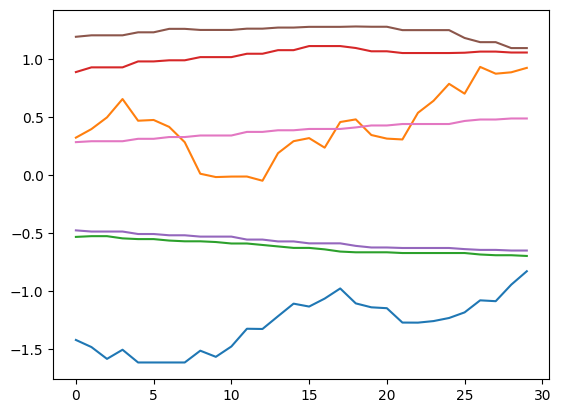

In [149]:

# plot past
for i in range(past_inputs.shape[0]):
    plt.plot(past_inputs[i, :].numpy())
for i in range(past_outputs.shape[0]):
    plt.plot(past_outputs[i, :].numpy())
for i in range(past_interals.shape[0]):
    plt.plot(past_interals[i, :].numpy())

In [21]:
# Import pytorch_lightning model
import pytorch_lightning as pl



from system_model import SysModel

In [22]:
sys_model = SysModel(
    num_past_time_steps = 30,
    num_input_vars = 2,
    num_output_vars = 1,
    num_internal_vars = 4,
)

In [37]:
def test_performance_of_model(sys_model, val_dataset):
    # Calculate the mean MSE of the model on the validation set
    dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True, num_workers=8)
    mean_mse = 0
    for past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals in dataloader:
        next_predicted_output, next_predicted_internal = sys_model(past_inputs, past_outputs, past_interals)
        mse = torch.mean((next_predicted_output - future_outputs)**2 + (next_predicted_internal - future_interals)**2)
        mean_mse += mse
    mean_mse /= len(dataloader)
    return mean_mse




In [38]:
# Test the performance of the model
test_performance_of_model(sys_model, val_dataset)
# tensor(0.0016, grad_fn=<DivBackward0>)
# tensor(0.0009, grad_fn=<DivBackward0>)
# tensor(0.0008, grad_fn=<DivBackward0>)

tensor(0.0008, grad_fn=<DivBackward0>)

In [36]:
# train model. log interval is set to 1
trainer = pl.Trainer(max_epochs=1, gpus=1)
trainer.fit(sys_model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv1d | 160   
1 | conv2 | Conv1d | 620   
2 | conv3 | Conv1d | 5.6 K 
3 | fc1   | Linear | 9.2 K 
4 | fc2   | Linear | 420   
5 | fc3   | Linear | 105   
---------------------------------
16.1 K    Trainable params
0         Non-trainable params
16.1 K    Total params
0.064     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.5760e-05, device='cuda:0', grad_fn=<Add

`Trainer.fit` stopped: `max_epochs=1` reached.


tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)


In [39]:
# save model
import datetime
now = datetime.datetime.now()

torch.save(sys_model.state_dict(), 'sys_model_{}.pt'.format(now.strftime("%Y-%m-%d_%H-%M-%S")))

In [42]:
ar_dataset = Dataset(
    df=train_df,
    num_time_steps_before=30,
    num_time_steps_after=100,
    transform=Transform(
        [5.867484, 5.720537],
        [4.866541,  4.8768854],
        [1619.3425],
        [158.12558],
        [-2.0340237e+03,  6.3358569e-01, -2.1668540e+03,  1.4289156e+01],
        [1.1323308e+03, 1.1938887e+00, 1.2715853e+03, 1.0630209e+00]
    )
)

In [43]:
# Create dataloader
ar_dataloader = DataLoader(ar_dataset, batch_size=1, shuffle=True, num_workers=8)

In [74]:
# Get a batch
past_inputs, past_outputs, past_interals, future_inputs, future_outputs, future_interals = next(iter(ar_dataloader))

In [53]:
'''
input:
    past_inputs: [batch_size, num_input_vars, num_past_time_steps]
    past_outputs: [batch_size, num_output_vars, num_past_time_steps]
    past_interals: [batch_size, num_internal_vars, num_past_time_steps]

output:
    next_predicted_output: [batch_size, num_output_vars, 1]
    next_predicted_internal: [batch_size, num_internal_vars, 1]

'''

'\ninput:\n    past_inputs: [batch_size, num_input_vars, num_past_time_steps]\n    past_outputs: [batch_size, num_output_vars, num_past_time_steps]\n    past_interals: [batch_size, num_internal_vars, num_past_time_steps]\n\noutput:\n    next_predicted_output: [batch_size, num_output_vars, 1]\n    next_predicted_internal: [batch_size, num_internal_vars, 1]\n\n'

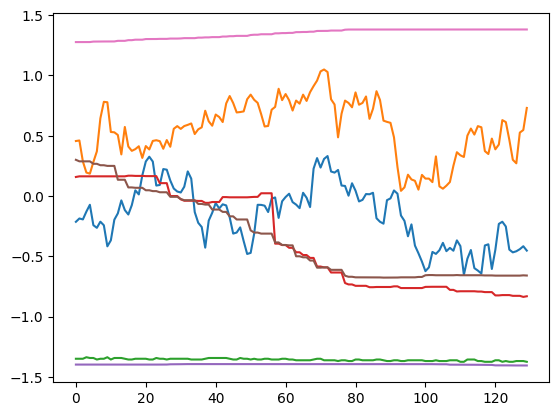

In [75]:
# plot
inputs = torch.cat((past_inputs, future_inputs), dim=2)
outputs = torch.cat((past_outputs, future_outputs), dim=2)
interals = torch.cat((past_interals, future_interals), dim=2)

for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].numpy())
for i in range(outputs.shape[1]):
    plt.plot(outputs[0, i, :].numpy())
for i in range(interals.shape[1]):
    plt.plot(interals[0, i, :].numpy())

In [57]:
inputs.shape[2]

130

In [76]:
window_size = 30

sys_model.eval()

outputs_predicted = outputs.clone()
interals_predicted = interals.clone()


for i in range(0, inputs.shape[2]- window_size):
    # concatenate past and future to get the model input

    next_predicted_output, next_predicted_internal = sys_model(inputs[:, :, i:i+window_size], outputs_predicted[:, :, i:i+window_size], interals_predicted[:, :, i:i+window_size])
    outputs_predicted[:, :, i+window_size] = next_predicted_output[:,:,0]
    interals_predicted[:, :, i+window_size] = next_predicted_internal[:,:,0]

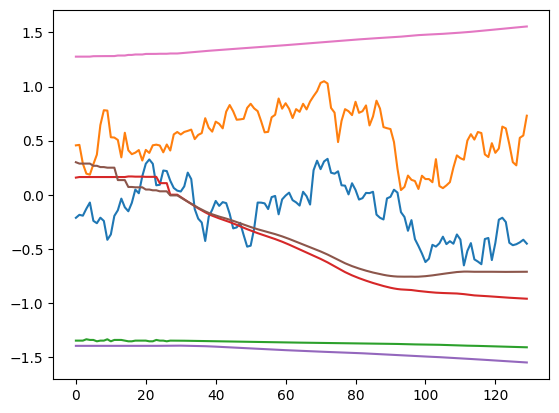

In [77]:

for i in range(inputs.shape[1]):
    plt.plot(inputs[0, i, :].numpy())
for i in range(outputs_predicted.shape[1]):
    plt.plot(outputs_predicted[0, i, :].detach().numpy())
for i in range(interals_predicted.shape[1]):
    plt.plot(interals_predicted[0, i, :].detach().numpy())

In [66]:
next_predicted_output[:,:,0].shape

torch.Size([1, 1])